In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import NMF
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
sns.set_palette("husl")

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### 데이터 로드 및 샘플링

In [4]:
data_path = Path("../data")

ratings_df = pd.read_csv(data_path / "user_ratings.csv")
print(f"전체 데이터: {len(ratings_df):,}행")


user_counts = ratings_df['Username'].value_counts()
active_users = user_counts[user_counts >= 50].index
print(f"활발한 사용자 (50+ 평가): {len(active_users):,}명")

game_counts = ratings_df['BGGId'].value_counts()
popular_games = game_counts[game_counts >= 100].index
print(f"인기 게임 (100+ 평가): {len(popular_games):,}개")

ratings_filtered = ratings_df[
    (ratings_df['Username'].isin(active_users)) & 
    (ratings_df['BGGId'].isin(popular_games))
].copy()

print(f"\n필터링 후 데이터: {len(ratings_filtered):,}행")
print(f"희소성 감소: {len(ratings_df):,} -> {len(ratings_filtered):,}")
print(f"압축률: {len(ratings_filtered)/len(ratings_df)*100:.2f}%")

del ratings_df

전체 데이터: 18,942,215행
활발한 사용자 (50+ 평가): 93,637명
인기 게임 (100+ 평가): 12,302개

필터링 후 데이터: 14,733,960행
희소성 감소: 18,942,215 -> 14,733,960
압축률: 77.78%


### 사용자-게임 ID 매핑

In [5]:
# 고유 사용자/게임 ID 생성
user_to_id = {user: idx for idx, user in enumerate(ratings_filtered['Username'].unique())}
game_to_id = {game: idx for idx, game in enumerate(ratings_filtered['BGGId'].unique())}

id_to_user = {idx: user for user, idx in user_to_id.items()}
id_to_game = {idx: game for game, idx in game_to_id.items()}

ratings_filtered['user_id'] = ratings_filtered['Username'].map(user_to_id)
ratings_filtered['game_id'] = ratings_filtered['BGGId'].map(game_to_id)

n_users = len(user_to_id)
n_games = len(game_to_id)

print(f"사용자 수: {n_users:,}")
print(f"게임 수: {n_games:,}")
print(f"매트릭스 크기: {n_users:,} x {n_games:,} = {n_users*n_games:,}")

사용자 수: 93,637
게임 수: 12,302
매트릭스 크기: 93,637 x 12,302 = 1,151,922,374


In [6]:
train_data, test_data = train_test_split(
    ratings_filtered, 
    test_size=0.2, 
    random_state=42
)

print(f"Train 데이터: {len(train_data):,}행")
print(f"Test 데이터: {len(test_data):,}행")

Train 데이터: 11,787,168행
Test 데이터: 2,946,792행


### Sparse Matrix 생성 
사용자-게임 평점 희소 행렬을 만들었음

In [7]:
def create_sparse_matrix(data, n_users, n_games):
    rows = data['user_id'].values
    cols = data['game_id'].values
    ratings = data['Rating'].values
    
    matrix = csr_matrix(
        (ratings, (rows, cols)), 
        shape=(n_users, n_games)
    )
    return matrix

train_matrix = create_sparse_matrix(train_data, n_users, n_games)
test_matrix = create_sparse_matrix(test_data, n_users, n_games)

print(f"Train Matrix: {train_matrix.shape}")
print(f"Train 희소성: {(1 - train_matrix.nnz / (n_users * n_games)) * 100:.4f}%")
print(f"Test Matrix: {test_matrix.shape}")

Train Matrix: (93637, 12302)
Train 희소성: 98.9784%
Test Matrix: (93637, 12302)


### Baseline 모델 #1 - Global Average

In [8]:
global_mean = train_data['Rating'].mean()
print(f"전역 평균 평점: {global_mean:.3f}")

# Test 데이터 예측
test_pred_global = np.full(len(test_data), global_mean)

rmse_global = np.sqrt(mean_squared_error(test_data['Rating'], test_pred_global))
mae_global = mean_absolute_error(test_data['Rating'], test_pred_global)

print(f"RMSE: {rmse_global:.4f}")
print(f"MAE: {mae_global:.4f}")


전역 평균 평점: 7.026
RMSE: 1.4977
MAE: 1.1138


### Baseline 모델 #2 - User Average

In [9]:
user_means = train_data.groupby('user_id')['Rating'].mean().to_dict()

test_pred_user = test_data['user_id'].map(user_means).fillna(global_mean)

rmse_user = np.sqrt(mean_squared_error(test_data['Rating'], test_pred_user))
mae_user = mean_absolute_error(test_data['Rating'], test_pred_user)

print(f"RMSE: {rmse_user:.4f}")
print(f"MAE: {mae_user:.4f}")
print(f"Global 대비 개선: {(rmse_global - rmse_user) / rmse_global * 100:.2f}%")

RMSE: 1.3535
MAE: 1.0203
Global 대비 개선: 9.63%


### Baseline 모델 #3 - Item Average

In [10]:
game_means = train_data.groupby('game_id')['Rating'].mean().to_dict()

test_pred_game = test_data['game_id'].map(game_means).fillna(global_mean)

rmse_game = np.sqrt(mean_squared_error(test_data['Rating'], test_pred_game))
mae_game = mean_absolute_error(test_data['Rating'], test_pred_game)

print(f"RMSE: {rmse_game:.4f}")
print(f"MAE: {mae_game:.4f}")
print(f"Global 대비 개선: {(rmse_global - rmse_game) / rmse_global * 100:.2f}%")

RMSE: 1.2923
MAE: 0.9792
Global 대비 개선: 13.71%


### Baseline 모델 #4 - User + Item Bias

In [11]:
# Bias 계산
user_bias = train_data.groupby('user_id')['Rating'].mean() - global_mean
game_bias = train_data.groupby('game_id')['Rating'].mean() - global_mean

user_bias_dict = user_bias.to_dict()
game_bias_dict = game_bias.to_dict()

# 예측: global_mean + user_bias + game_bias
test_pred_bias = (
    global_mean + 
    test_data['user_id'].map(user_bias_dict).fillna(0) +
    test_data['game_id'].map(game_bias_dict).fillna(0)
)

# 평점 범위 제한 (1~10)
test_pred_bias = test_pred_bias.clip(1, 10)

rmse_bias = np.sqrt(mean_squared_error(test_data['Rating'], test_pred_bias))
mae_bias = mean_absolute_error(test_data['Rating'], test_pred_bias)

print(f"RMSE: {rmse_bias:.4f}")
print(f"MAE: {mae_bias:.4f}")
print(f"Global 대비 개선: {(rmse_global - rmse_bias) / rmse_global * 100:.2f}%")

RMSE: 1.1960
MAE: 0.9041
Global 대비 개선: 20.15%


In [ ]:
# # NMF 예측 전에 확인해보세요
# print(f"\n=== NMF 진단 ===")
# print(f"W shape: {W.shape}")
# print(f"H shape: {H.shape}")
# print(f"test_data user_id 범위: {test_data['user_id'].min()} ~ {test_data['user_id'].max()}")
# print(f"test_data game_id 범위: {test_data['game_id'].min()} ~ {test_data['game_id'].max()}")

# # 몇 개 샘플 확인
# print(f"\n테스트 샘플:")
# print(test_data[['user_id', 'game_id', 'Rating']].head(10))

# # 예측값 몇 개 확인
# test_pred_nmf = predicted_ratings[test_data['user_id'].values, 
#                                   test_data['game_id'].values]
# print(f"\n예측값 샘플: {test_pred_nmf[:10]}")
# print(f"예측값 범위: {test_pred_nmf.min():.2f} ~ {test_pred_nmf.max():.2f}")
# print(f"실제값 범위: {test_data['Rating'].min()} ~ {test_data['Rating'].max()}")


=== NMF 진단 ===
W shape: (93637, 50)
H shape: (50, 12302)
test_data user_id 범위: 0 ~ 93636
test_data game_id 범위: 0 ~ 12301

테스트 샘플:
          user_id  game_id  Rating
7595986      4033     3612     7.0
8522613      6033     3731     6.5
4129667     22419     3369     7.0
13765616     5360     4423     8.0
14681876    11128     4627     9.0
11178260    37316     4034     8.0
9443483     49087     3604     7.0
8995859     55025     4042     7.0
7682972     52225     3781     4.0
12379777    51706     4113     9.0

예측값 샘플: [1.66069132 4.21616616 4.30821635 2.79078267 1.35221456 0.36901358
 1.89049895 0.29883434 2.51706108 0.54334037]
예측값 범위: 0.00 ~ 47.88
실제값 범위: 0.001 ~ 10.0


In [ ]:
# print(f"\n=== 예측값 분석 ===")
# print(f"정규화 후 예측값 통계:")
# print(f"  평균: {test_pred_nmf.mean():.2f}")
# print(f"  중앙값: {np.median(test_pred_nmf):.2f}")
# print(f"  표준편차: {test_pred_nmf.std():.2f}")

# print(f"\n실제값 통계:")
# print(f"  평균: {test_data['Rating'].mean():.2f}")
# print(f"  중앙값: {test_data['Rating'].median():.2f}")
# print(f"  표준편차: {test_data['Rating'].std():.2f}")

# # 예측값과 실제값 비교 (샘플)
# print(f"\n샘플 비교 (처음 20개):")
# comparison = pd.DataFrame({
#     '실제값': test_data['Rating'].iloc[:20].values,
#     '예측값': test_pred_nmf[:20]
# })
# print(comparison)


=== 예측값 분석 ===
정규화 후 예측값 통계:
  평균: 1.23
  중앙값: 1.13
  표준편차: 0.27

실제값 통계:
  평균: 7.03
  중앙값: 7.00
  표준편차: 1.50

샘플 비교 (처음 20개):
    실제값       예측값
0   7.0  1.312163
1   6.5  1.792520
2   7.0  1.809823
3   8.0  1.524588
4   9.0  1.254178
5   8.0  1.069364
6   7.0  1.355361
7   7.0  1.056172
8   4.0  1.473137
9   9.0  1.102133
10  8.0  1.020300
11  7.0  1.004322
12  7.5  1.019496
13  7.0  1.004285
14  8.0  1.000000
15  8.0  1.188486
16  8.0  1.222072
17  8.0  1.080387
18  6.5  1.040230
19  7.0  1.001940


In [20]:
results = pd.DataFrame({
    'Model': [
        'Global Average',
        'User Average',
        'Game Average',
        'User + Game Bias'
    ],
    'RMSE': [rmse_global, rmse_user, rmse_game, rmse_bias],
    'MAE': [mae_global, mae_user, mae_game, mae_bias]
})

results = results.sort_values('RMSE')

print("\n모델 성능 순위:")
print(results.to_string(index=False))

best_baseline = results.iloc[0]
print(f"\n최고 성능 모델: {best_baseline['Model']}")
print(f"  - RMSE: {best_baseline['RMSE']:.4f}")
print(f"  - MAE: {best_baseline['MAE']:.4f}")


모델 성능 순위:
           Model     RMSE      MAE
User + Game Bias 1.195955 0.904053
    Game Average 1.292269 0.979162
    User Average 1.353460 1.020271
  Global Average 1.497662 1.113826

최고 성능 모델: User + Game Bias
  - RMSE: 1.1960
  - MAE: 0.9041


###  모델 성능 비교

In [21]:
results = pd.DataFrame({
    'Model': [
        'Global Average',
        'User Average',
        'Game Average',
        'User + Game Bias'
    ],
    'RMSE': [rmse_global, rmse_user, rmse_game, rmse_bias],
    'MAE': [mae_global, mae_user, mae_game, mae_bias]
})

results = results.sort_values('RMSE')
print("\n모델 성능 순위:")
print(results.to_string(index=False))


모델 성능 순위:
           Model     RMSE      MAE
User + Game Bias 1.195955 0.904053
    Game Average 1.292269 0.979162
    User Average 1.353460 1.020271
  Global Average 1.497662 1.113826


### 시각화

저장: ..\outputs\figures\03_baseline_comparison.png


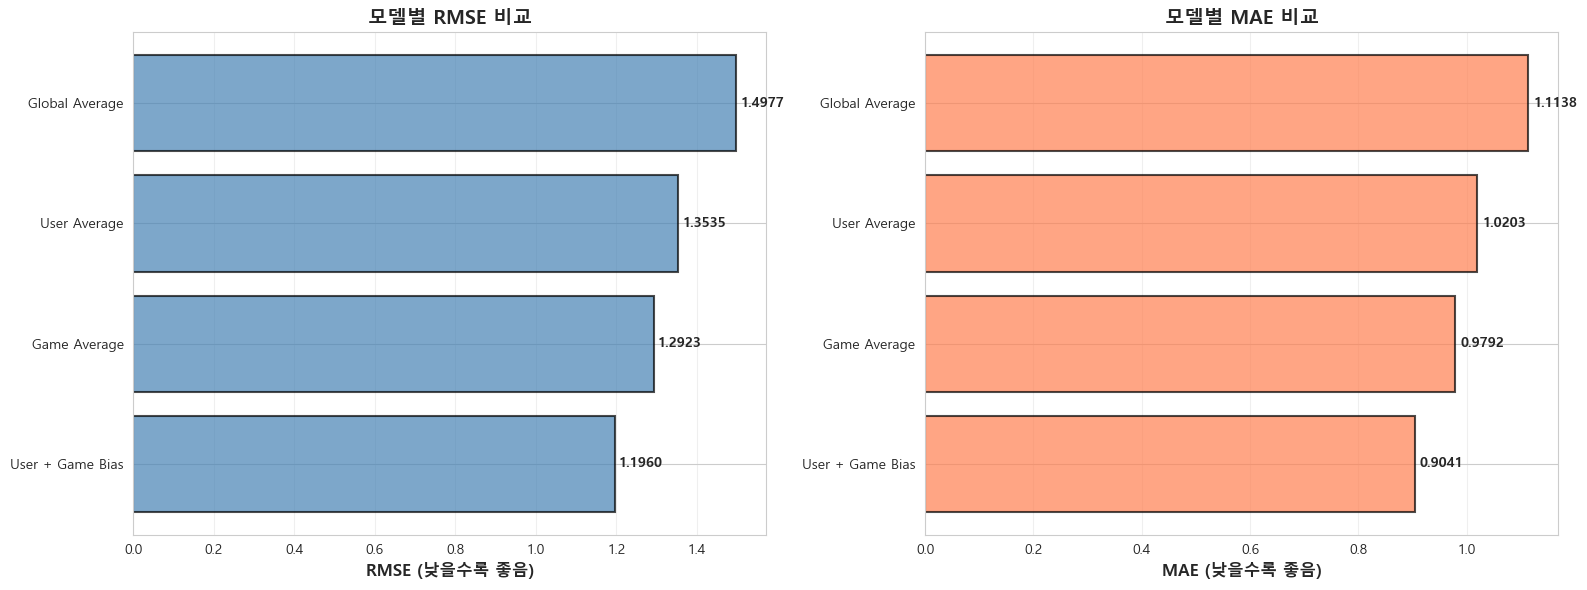

저장: ..\outputs\figures\04_prediction_scatter.png


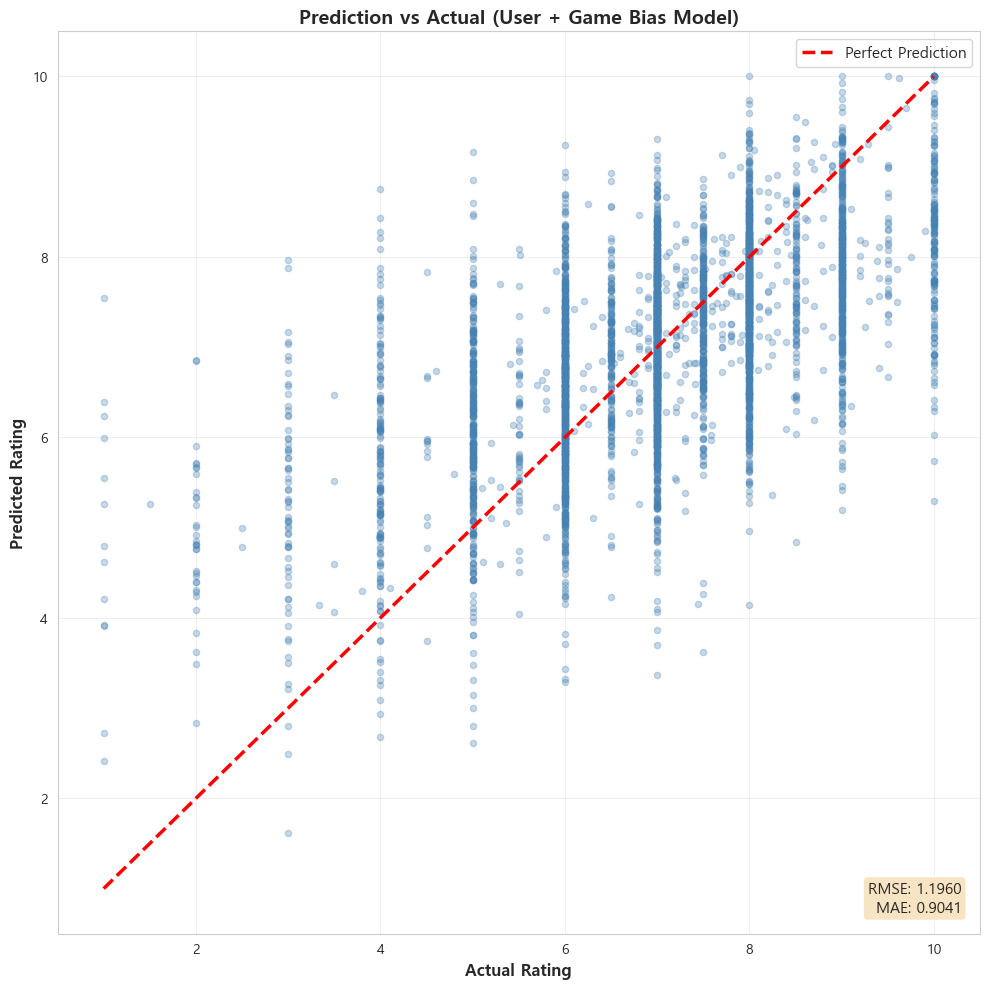

In [22]:
output_path = Path("../outputs/figures")
output_path.mkdir(parents=True, exist_ok=True)

# Figure 1: 모델 성능 비교
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RMSE 비교
axes[0].barh(results['Model'], results['RMSE'], color='steelblue', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('RMSE (낮을수록 좋음)', fontsize=12, fontweight='bold')
axes[0].set_title('모델별 RMSE 비교', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

for i, v in enumerate(results['RMSE']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

# MAE 비교
axes[1].barh(results['Model'], results['MAE'], color='coral', alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_xlabel('MAE (낮을수록 좋음)', fontsize=12, fontweight='bold')
axes[1].set_title('모델별 MAE 비교', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')

for i, v in enumerate(results['MAE']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(output_path / '03_baseline_comparison.png', dpi=300, bbox_inches='tight')
print(f"저장: {output_path / '03_baseline_comparison.png'}")
plt.show()
plt.close()

# Figure 2: 예측 vs 실제 (Best Model)
fig, ax = plt.subplots(figsize=(10, 10))

# 샘플링
sample_indices = np.random.choice(len(test_data), size=min(5000, len(test_data)), replace=False)
test_sample = test_data.iloc[sample_indices].reset_index(drop=True)
pred_sample = test_pred_bias.iloc[sample_indices].reset_index(drop=True)

ax.scatter(test_sample['Rating'], pred_sample, alpha=0.3, s=20, color='steelblue')
ax.plot([1, 10], [1, 10], 'r--', linewidth=2.5, label='Perfect Prediction')
ax.set_xlabel('Actual Rating', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted Rating', fontsize=12, fontweight='bold')
ax.set_xlim(0.5, 10.5)
ax.set_ylim(0.5, 10.5)
ax.set_title('Prediction vs Actual (User + Game Bias Model)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# 추가 정보
textstr = f'RMSE: {rmse_bias:.4f}\nMAE: {mae_bias:.4f}'
ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig(output_path / '04_prediction_scatter.png', dpi=300, bbox_inches='tight')
print(f"저장: {output_path / '04_prediction_scatter.png'}")
plt.show()
plt.close()

### 저장

In [23]:
output_models_path = Path("../outputs/models")
output_reports_path = Path("../outputs/reports")
output_models_path.mkdir(parents=True, exist_ok=True)
output_reports_path.mkdir(parents=True, exist_ok=True)

# 저장할 데이터
model_data = {
    'global_mean': global_mean,
    'user_bias_dict': user_bias_dict,
    'game_bias_dict': game_bias_dict,
    'user_means': user_means,
    'game_means': game_means,
    'user_to_id': user_to_id,
    'game_to_id': game_to_id,
    'id_to_user': id_to_user,
    'id_to_game': id_to_game
}

import pickle

with open(output_models_path / 'baseline_models.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print(f"저장: {output_models_path / 'baseline_models.pkl'}")

# 성능 결과 저장
results.to_csv(output_reports_path / 'baseline_results.csv', index=False)
print(f"저장: {output_reports_path / 'baseline_results.csv'}")

저장: ..\outputs\models\baseline_models.pkl
저장: ..\outputs\reports\baseline_results.csv


### summary

In [24]:
print("\n최고 성능 모델:")
best_model = results.iloc[0]
print(f"   모델: {best_model['Model']}")
print(f"   RMSE: {best_model['RMSE']:.4f}")
print(f"   MAE: {best_model['MAE']:.4f}")

print("\n생성된 파일:")
print(f"   [시각화]")
print(f"   - {output_path / '03_baseline_comparison.png'}")
print(f"   - {output_path / '04_prediction_scatter.png'}")
print(f"   [모델]")
print(f"   - {output_models_path / 'baseline_models.pkl'}")
print(f"   [보고서]")
print(f"   - {output_reports_path / 'baseline_results.csv'}")


최고 성능 모델:
   모델: User + Game Bias
   RMSE: 1.1960
   MAE: 0.9041

생성된 파일:
   [시각화]
   - ..\outputs\figures\03_baseline_comparison.png
   - ..\outputs\figures\04_prediction_scatter.png
   [모델]
   - ..\outputs\models\baseline_models.pkl
   [보고서]
   - ..\outputs\reports\baseline_results.csv
